In [148]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/star-dataset/6 class csv.csv


# In this dataset I wanted to make a Machine Learning model to predict star type from the other variables, and learn more about data science concepts along the way
# Made possible thanks to the below sources:
https://jayant017.medium.com/hyperparameter-tuning-in-xgboost-using-randomizedsearchcv-88fcb5b58a73

https://www.youtube.com/watch?v=ap2SS0-XPcE

https://www.kaggle.com/learn/intermediate-machine-learning

# Begin importing dataset and printing head

In [149]:
df = pd.read_csv('/kaggle/input/star-dataset/6 class csv.csv')
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


# I was interested in seeing some bivariate correlations, used scatterplot to see any relationships

<AxesSubplot:xlabel='Temperature (K)', ylabel='Spectral Class'>

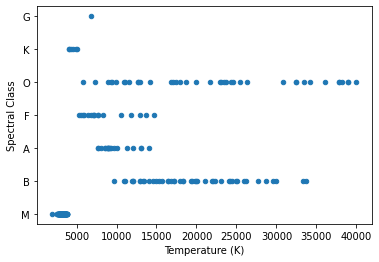

In [150]:
df.plot.scatter(x = 'Temperature (K)', y = 'Spectral Class')

<AxesSubplot:xlabel='Temperature (K)', ylabel='Star type'>

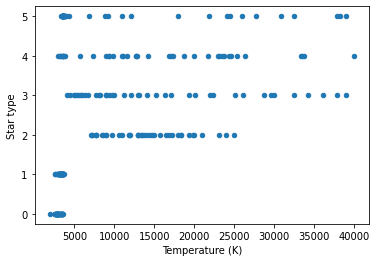

In [151]:
df.plot.scatter(x = 'Temperature (K)', y = 'Star type')

# Radius vs Star Type seems to have an emergent pattern, an interesting insight

<AxesSubplot:xlabel='Radius(R/Ro)', ylabel='Star type'>

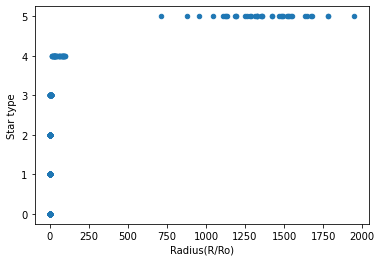

In [152]:
df.plot.scatter(x = 'Radius(R/Ro)', y = 'Star type')

# Another strong emergent pattern appears in Absolute Magnitude vs Star Type, I suspect this would make a ML model's accuracy greatly helped with this data if used to test real world star data (which we are), due to the neatness of the data

<AxesSubplot:xlabel='Absolute magnitude(Mv)', ylabel='Star type'>

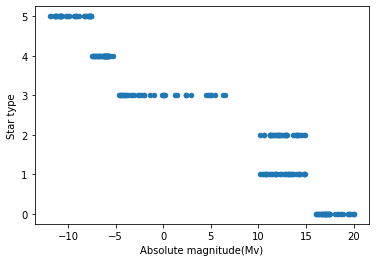

In [153]:
df.plot.scatter(x = 'Absolute magnitude(Mv)', y = 'Star type')

<AxesSubplot:xlabel='Star color', ylabel='Temperature (K)'>

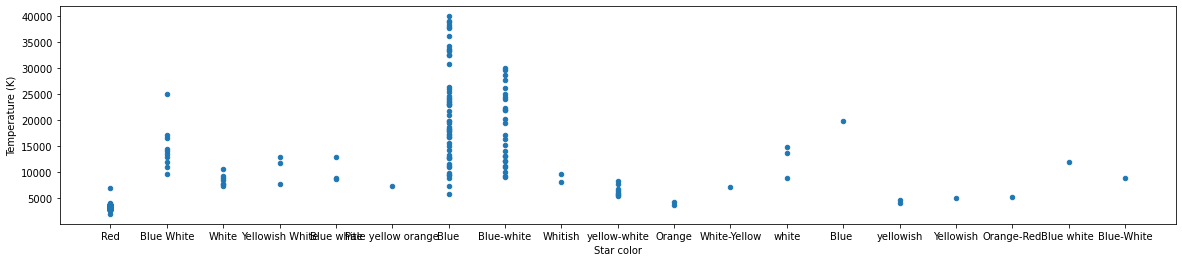

In [154]:
df.plot.scatter(x = 'Star color', y = 'Temperature (K)', figsize=(20, 4))

# After seeing these relationships, its time to see how our data fits in with the Hertzsprung-Russell Diagram
<img src="https://chandra.harvard.edu/graphics/edu/formal/variable_stars/HR_diagram.jpg" alt="HR Diagram" width="500"/>

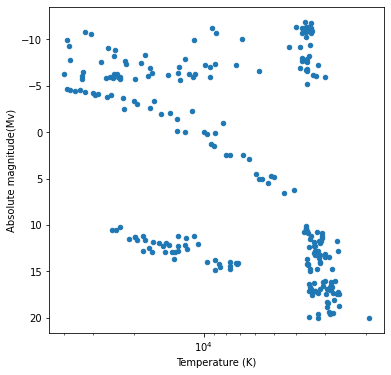

In [175]:
HRGraph = df.plot.scatter(x = 'Temperature (K)', y = 'Absolute magnitude(Mv)', figsize=(6, 6))
HRGraph.set_xscale('log')
HRGraph.invert_xaxis()
HRGraph.invert_yaxis()

# ^ It fits in moderately well, white dwarfs, giants, and main sequence patterns can be distinctly made out

# Before passing in values to a ML model, let's see our categorical variables - the model cannot interpret those

In [156]:
df.dtypes

Temperature (K)             int64
Luminosity(L/Lo)          float64
Radius(R/Ro)              float64
Absolute magnitude(Mv)    float64
Star type                   int64
Star color                 object
Spectral Class             object
dtype: object

# Spectral Class and Star Color are 2 categorical variables, we can see these below

In [157]:
cat_col= [col for col in df.columns if df[col].dtype == 'object']

for col in cat_col:
    print('{} has {} values '.format(col,df[col].unique()) + '\n')

Star color has ['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White'] values 

Spectral Class has ['M' 'B' 'A' 'F' 'O' 'K' 'G'] values 



# Let's convert these to numerical values using LabelEncoder module

In [171]:
from sklearn.preprocessing import LabelEncoder

for col in cat_col:
    df[col] = LabelEncoder().fit_transform(df[col])

# Let's confirm what our transformed categorical variables look like

In [159]:
for col in cat_col:
    print('{} has {} values'.format(col,df[col].unique()) + '\n')

Star color has [10  2 11 15  3  9  0  6 13 17  7 12 16  1 18 14  8  4  5] values

Spectral Class has [5 1 0 2 6 4 3] values



# Discrete integers can now be processed onto the ML model, we verify by looking at all types now

In [160]:
df.dtypes

Temperature (K)             int64
Luminosity(L/Lo)          float64
Radius(R/Ro)              float64
Absolute magnitude(Mv)    float64
Star type                   int64
Star color                  int64
Spectral Class              int64
dtype: object

# We now create independent and dependent variables, i.e. feature and target variables. Star type will be target

In [161]:
ind_col = [col for col in df.columns if col!='Star type']
dep_col = 'Star type'
X = df[ind_col]
Y = df[dep_col]
X.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,10,5
1,3042,0.000500,0.1542,16.60,10,5
2,2600,0.000300,0.1020,18.70,10,5
3,2800,0.000200,0.1600,16.65,10,5
4,1939,0.000138,0.1030,20.06,10,5


# Data dimensions for both total datasets are below

In [162]:
print('X Shape:' + str(X.shape) + '| Y Shape: ' + str(Y.shape))

X Shape:(240, 6)| Y Shape: (240,)


# Let's split our data into training the model and testing model. A common an effective ratio usually is 80/20 so we'll do that

In [163]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=0, test_size=0.2)
print('X Shape:' + str(X_train.shape) + '| Y Shape: ' + str(Y_test.shape))

X Shape:(192, 6)| Y Shape: (48,)


# Now we import the ML module to generate a model - XGBoost is a strong library for this

In [164]:
from xgboost import XGBClassifier

# We also want cross-validation as it can make the ML model more reliable in predicting new sets of data by gaining training exposure to different subsets in the training set

In [165]:
classifier = XGBClassifier()

params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
}

from sklearn.model_selection import RandomizedSearchCV

rs_cv=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
rs_cv.fit(X_train, Y_train)

rs_cv.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  category=UserWarning,


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

# The RandomizedSearchCV library gives us the optimal parameters for the Classifier Model, now we have a working model to test

In [166]:
classifier = XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=7,
              monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0)
classifier.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

# Let's see how our model did in predicting star types

In [172]:
Y_pred = classifier.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score

accuracy_score(Y_test, Y_pred)

1.0

# We got a 100% accuracy rate in predicting star types! That's a very neat model

In [173]:
cm = confusion_matrix(Y_test, Y_pred)
cm

array([[ 7,  0,  0,  0,  0,  0],
       [ 0,  9,  0,  0,  0,  0],
       [ 0,  0,  7,  0,  0,  0],
       [ 0,  0,  0,  8,  0,  0],
       [ 0,  0,  0,  0, 11,  0],
       [ 0,  0,  0,  0,  0,  6]])

# We see the breakdown of how many and which stars it categorized into its respective type
# These numbers make sense as if you sum them, you get the number of values in Y_test - our testing dataset!

In [174]:
sum = 0
for x in cm:
    for y in x:
        sum+=y
        
print(sum)

48
